<a href="https://colab.research.google.com/github/saksham1211/Marketingai_Internship/blob/master/%5BPYTORCH%5DLogo_Detection_of_investment_companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Test/Train split**

In [0]:
import glob
import os
import numpy as np
import sys

current_dir = "/content/drive/My Drive/FINAL_PYTORCH_DATA/images"
split_pct = 30;
file_train = open("/content/drive/My Drive/FINAL_PYTORCH_DATA/train.txt", "w")  
file_val = open("/content/drive/My Drive/FINAL_PYTORCH_DATA/valid.txt", "w")  
counter = 1  
index_test = round(100 / split_pct)  
for pathAndFilename in glob.iglob(os.path.join(current_dir, "*.jpg")):  
        title, ext = os.path.splitext(os.path.basename(pathAndFilename))
        if counter == index_test:
                counter = 1
                file_val.write(current_dir + "/" + title + '.jpg' + "\n")
        else:
                file_train.write(current_dir + "/" + title + '.jpg' + "\n")
                counter = counter + 1
file_train.close()
file_val.close()


### **TRAINING AND DETECTION**

In [1]:
from __future__ import division

from models import *
from utils import *
from datasets import *
from parse_config import *

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim

parser = argparse.ArgumentParser()
parser.add_argument("-f")
parser.add_argument("--epochs", type=int, default=50, help="number of epochs")
parser.add_argument("--image_folder", type=str, default="/content/drive/My Drive/FINAL_PYTORCH_DATA/images", help="path to dataset")
parser.add_argument("--batch_size", type=int, default=16, help="size of each image batch")
parser.add_argument("--model_config_path", type=str, default="/content/drive/My Drive/config/yolov3.cfg", help="path to model config file")
parser.add_argument("--data_config_path", type=str, default="/content/drive/My Drive/config/coco.data", help="path to data config file")
parser.add_argument("--weights_path", type=str, default="/content/drive/My Drive/config/yolov3.weights", help="path to weights file")
parser.add_argument("--class_path", type=str, default="/content/drive/My Drive/config/coco.names", help="path to class label file")
parser.add_argument("--conf_thres", type=float, default=0.8, help="object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.4, help="iou thresshold for non-maximum suppression")
parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--checkpoint_dir", type=str, default="/content/checkpoints", help="directory where model checkpoints are saved")
parser.add_argument("--use_cuda", type=bool, default=True, help="whether to use cuda if available")
opt = parser.parse_args()
print(opt)

cuda = torch.cuda.is_available() and opt.use_cuda

os.makedirs("checkpoints", exist_ok=True)

classes = load_classes(opt.class_path)

# Get data configuration
data_config = parse_data_config(opt.data_config_path)
train_path = data_config["train"]

# Get hyper parameters
hyperparams = parse_model_config(opt.model_config_path)[0]
learning_rate = float(hyperparams["learning_rate"])
momentum = float(hyperparams["momentum"])
decay = float(hyperparams["decay"])
burn_in = int(hyperparams["burn_in"])

# Initiate model
model = Darknet(opt.model_config_path)
model.load_weights(opt.weights_path)
#model.apply(weights_init_normal)

if cuda:
    model = model.cuda()

model.train()

# Get dataloader
dataloader = torch.utils.data.DataLoader(
    ListDataset(train_path), batch_size=opt.batch_size, shuffle=False, num_workers=opt.n_cpu
)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

for epoch in range(opt.epochs):
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        imgs = Variable(imgs.type(Tensor))
        targets = Variable(targets.type(Tensor), requires_grad=False)

        optimizer.zero_grad()

        loss = model(imgs, targets)

        loss.backward()
        optimizer.step()

        print(
            "[Epoch %d/%d, Batch %d/%d] [Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f, precision: %.5f]"
            % (
                epoch,
                opt.epochs,
                batch_i,
                len(dataloader),
                model.losses["x"],
                model.losses["y"],
                model.losses["w"],
                model.losses["h"],
                model.losses["conf"],
                model.losses["cls"],
                loss.item(),
                model.losses["recall"],
                model.losses["precision"],
            )
        )

        model.seen += imgs.size(0)

    if epoch % opt.checkpoint_interval == 0:
        model.save_weights("%s%d.weights" % (opt.checkpoint_dir, epoch))
        
        

Namespace(batch_size=16, checkpoint_dir='/content/checkpoints', checkpoint_interval=1, class_path='/content/drive/My Drive/config/coco.names', conf_thres=0.8, data_config_path='/content/drive/My Drive/config/coco.data', epochs=50, f='/root/.local/share/jupyter/runtime/kernel-ef88a39a-9a1d-4a2d-ad18-b26ca98b12dd.json', image_folder='/content/drive/My Drive/FINAL_PYTORCH_DATA/images', img_size=416, model_config_path='/content/drive/My Drive/config/yolov3.cfg', n_cpu=0, nms_thres=0.4, use_cuda=True, weights_path='/content/drive/My Drive/config/yolov3.weights')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/Ind

[Epoch 0/50, Batch 0/1] [Losses: x 0.343351, y 0.266242, w 2.154953, h 3.225978, conf 13.133509, cls 0.706209, total 19.830242, recall: 0.02381, precision: 0.00002]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 1/50, Batch 0/1] [Losses: x 0.335700, y 0.213232, w 0.425286, h 2.092392, conf 2.933914, cls 0.705076, total 6.705598, recall: 0.14286, precision: 0.00008]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 2/50, Batch 0/1] [Losses: x 0.331568, y 0.175127, w 0.819215, h 5.493886, conf 3.006325, cls 0.703380, total 10.529500, recall: 0.14286, precision: 0.00010]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 3/50, Batch 0/1] [Losses: x 0.294939, y 0.207751, w 0.706755, h 1.566683, conf 4.221189, cls 0.699739, total 7.697055, recall: 0.19048, precision: 0.00020]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 4/50, Batch 0/1] [Losses: x 0.290596, y 0.167774, w 0.127219, h 0.903423, conf 3.137373, cls 0.698565, total 5.324949, recall: 0.28571, precision: 0.00184]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 5/50, Batch 0/1] [Losses: x 0.260832, y 0.152685, w 0.163739, h 0.615386, conf 3.025995, cls 0.695455, total 4.914092, recall: 0.38095, precision: 0.00432]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 6/50, Batch 0/1] [Losses: x 0.233656, y 0.145410, w 0.077028, h 0.455839, conf 2.798804, cls 0.690418, total 4.401155, recall: 0.35714, precision: 0.00356]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 7/50, Batch 0/1] [Losses: x 0.231373, y 0.147734, w 0.049183, h 0.266662, conf 2.615437, cls 0.687906, total 3.998296, recall: 0.33333, precision: 0.00326]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 8/50, Batch 0/1] [Losses: x 0.210500, y 0.135166, w 0.050978, h 0.156668, conf 2.447525, cls 0.682289, total 3.683127, recall: 0.33333, precision: 0.00380]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 9/50, Batch 0/1] [Losses: x 0.195273, y 0.122885, w 0.039133, h 0.150412, conf 2.293583, cls 0.677726, total 3.479012, recall: 0.33333, precision: 0.00411]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 10/50, Batch 0/1] [Losses: x 0.185041, y 0.117977, w 0.039123, h 0.081289, conf 2.156562, cls 0.674266, total 3.254259, recall: 0.33333, precision: 0.00416]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 11/50, Batch 0/1] [Losses: x 0.170495, y 0.112116, w 0.030724, h 0.061081, conf 2.062807, cls 0.669612, total 3.106836, recall: 0.33333, precision: 0.00480]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 12/50, Batch 0/1] [Losses: x 0.155243, y 0.103553, w 0.035215, h 0.049305, conf 1.964858, cls 0.662728, total 2.970903, recall: 0.33333, precision: 0.00578]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 13/50, Batch 0/1] [Losses: x 0.145769, y 0.098246, w 0.031452, h 0.042915, conf 1.892086, cls 0.655261, total 2.865729, recall: 0.33333, precision: 0.00583]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 14/50, Batch 0/1] [Losses: x 0.138270, y 0.091760, w 0.020964, h 0.039409, conf 1.836855, cls 0.647566, total 2.774824, recall: 0.33333, precision: 0.00583]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 15/50, Batch 0/1] [Losses: x 0.126566, y 0.081112, w 0.017185, h 0.041186, conf 1.756844, cls 0.640136, total 2.663028, recall: 0.28571, precision: 0.00488]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 16/50, Batch 0/1] [Losses: x 0.116519, y 0.071486, w 0.016258, h 0.040818, conf 1.697968, cls 0.632205, total 2.575255, recall: 0.28571, precision: 0.00476]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 17/50, Batch 0/1] [Losses: x 0.108740, y 0.064894, w 0.013297, h 0.025627, conf 1.652106, cls 0.622902, total 2.487566, recall: 0.28571, precision: 0.00500]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 18/50, Batch 0/1] [Losses: x 0.097081, y 0.058886, w 0.011157, h 0.021896, conf 1.613323, cls 0.613888, total 2.416231, recall: 0.28571, precision: 0.00493]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 19/50, Batch 0/1] [Losses: x 0.082335, y 0.052155, w 0.005185, h 0.022165, conf 1.579523, cls 0.604875, total 2.346237, recall: 0.28571, precision: 0.00483]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 20/50, Batch 0/1] [Losses: x 0.071969, y 0.045183, w 0.008575, h 0.017484, conf 1.554905, cls 0.595955, total 2.294072, recall: 0.28571, precision: 0.00436]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 21/50, Batch 0/1] [Losses: x 0.066127, y 0.041629, w 0.009509, h 0.021498, conf 1.528890, cls 0.586226, total 2.253879, recall: 0.33333, precision: 0.00571]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 22/50, Batch 0/1] [Losses: x 0.054502, y 0.035273, w 0.008351, h 0.019975, conf 1.511506, cls 0.578562, total 2.208169, recall: 0.33333, precision: 0.00515]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 23/50, Batch 0/1] [Losses: x 0.045928, y 0.031365, w 0.010774, h 0.011823, conf 1.491237, cls 0.570523, total 2.161651, recall: 0.42857, precision: 0.00895]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 24/50, Batch 0/1] [Losses: x 0.041843, y 0.028119, w 0.006558, h 0.009786, conf 1.472554, cls 0.563898, total 2.122757, recall: 0.42857, precision: 0.00969]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 25/50, Batch 0/1] [Losses: x 0.035970, y 0.024667, w 0.007461, h 0.008905, conf 1.454637, cls 0.558638, total 2.090278, recall: 0.47619, precision: 0.01220]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 26/50, Batch 0/1] [Losses: x 0.030979, y 0.020913, w 0.007058, h 0.007156, conf 1.435988, cls 0.554143, total 2.056236, recall: 0.45238, precision: 0.01112]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 27/50, Batch 0/1] [Losses: x 0.027185, y 0.018015, w 0.006867, h 0.008491, conf 1.419088, cls 0.550807, total 2.030453, recall: 0.45238, precision: 0.01145]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 28/50, Batch 0/1] [Losses: x 0.024211, y 0.015715, w 0.003803, h 0.006662, conf 1.402577, cls 0.548833, total 2.001801, recall: 0.45238, precision: 0.01251]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 29/50, Batch 0/1] [Losses: x 0.022020, y 0.013240, w 0.003266, h 0.007771, conf 1.386997, cls 0.547475, total 1.980769, recall: 0.45238, precision: 0.01337]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 30/50, Batch 0/1] [Losses: x 0.019519, y 0.011934, w 0.003919, h 0.008040, conf 1.370344, cls 0.546383, total 1.960139, recall: 0.45238, precision: 0.01375]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 31/50, Batch 0/1] [Losses: x 0.018113, y 0.010370, w 0.002854, h 0.005546, conf 1.354498, cls 0.545661, total 1.937042, recall: 0.47619, precision: 0.01542]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 32/50, Batch 0/1] [Losses: x 0.016112, y 0.008816, w 0.003665, h 0.005539, conf 1.339853, cls 0.545154, total 1.919139, recall: 0.47619, precision: 0.01783]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 33/50, Batch 0/1] [Losses: x 0.013454, y 0.008480, w 0.003198, h 0.007756, conf 1.322867, cls 0.544755, total 1.900509, recall: 0.54762, precision: 0.02355]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 34/50, Batch 0/1] [Losses: x 0.011889, y 0.007903, w 0.009794, h 0.017537, conf 1.306981, cls 0.544530, total 1.898634, recall: 0.54762, precision: 0.02474]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 35/50, Batch 0/1] [Losses: x 0.009798, y 0.007551, w 0.008818, h 0.029801, conf 1.292463, cls 0.544230, total 1.892661, recall: 0.57143, precision: 0.02755]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 36/50, Batch 0/1] [Losses: x 0.008553, y 0.006915, w 0.002755, h 0.019373, conf 1.275212, cls 0.543924, total 1.856732, recall: 0.54762, precision: 0.02817]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 37/50, Batch 0/1] [Losses: x 0.007331, y 0.006581, w 0.004310, h 0.010920, conf 1.259476, cls 0.543663, total 1.832281, recall: 0.54762, precision: 0.02987]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 38/50, Batch 0/1] [Losses: x 0.006930, y 0.006759, w 0.002417, h 0.012006, conf 1.244897, cls 0.543494, total 1.816504, recall: 0.54762, precision: 0.03467]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 39/50, Batch 0/1] [Losses: x 0.006243, y 0.006449, w 0.001485, h 0.010414, conf 1.229341, cls 0.543309, total 1.797242, recall: 0.50000, precision: 0.02942]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 40/50, Batch 0/1] [Losses: x 0.005170, y 0.005854, w 0.002088, h 0.007391, conf 1.214543, cls 0.543109, total 1.778155, recall: 0.50000, precision: 0.03196]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 41/50, Batch 0/1] [Losses: x 0.004953, y 0.005120, w 0.001812, h 0.006959, conf 1.199609, cls 0.542854, total 1.761307, recall: 0.50000, precision: 0.03351]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 42/50, Batch 0/1] [Losses: x 0.004154, y 0.004558, w 0.001886, h 0.009090, conf 1.184633, cls 0.542615, total 1.746937, recall: 0.45238, precision: 0.03460]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 43/50, Batch 0/1] [Losses: x 0.003698, y 0.004226, w 0.001622, h 0.008168, conf 1.170678, cls 0.542339, total 1.730732, recall: 0.45238, precision: 0.03867]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 44/50, Batch 0/1] [Losses: x 0.003261, y 0.004334, w 0.003238, h 0.006145, conf 1.155621, cls 0.542018, total 1.714616, recall: 0.47619, precision: 0.03871]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 45/50, Batch 0/1] [Losses: x 0.003189, y 0.004246, w 0.002341, h 0.008360, conf 1.140813, cls 0.541663, total 1.700610, recall: 0.50000, precision: 0.04330]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 46/50, Batch 0/1] [Losses: x 0.003181, y 0.003769, w 0.004061, h 0.012983, conf 1.125088, cls 0.541350, total 1.690433, recall: 0.50000, precision: 0.04354]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 47/50, Batch 0/1] [Losses: x 0.003231, y 0.004021, w 0.011237, h 0.017694, conf 1.112300, cls 0.541078, total 1.689562, recall: 0.50000, precision: 0.05204]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 48/50, Batch 0/1] [Losses: x 0.003310, y 0.004103, w 0.020206, h 0.037024, conf 1.097320, cls 0.540708, total 1.702671, recall: 0.50000, precision: 0.04506]


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

[Epoch 49/50, Batch 0/1] [Losses: x 0.003186, y 0.005004, w 0.032433, h 0.068066, conf 1.088138, cls 0.540631, total 1.737460, recall: 0.52381, precision: 0.06736]


In [0]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import utils

In [11]:

config_path='/content/drive/My Drive/config/yolov3.cfg'
weights_path='/content/drive/My Drive/config/checkpoints49.weights'
class_path='/content/drive/My Drive/config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.110840


<Figure size 432x288 with 0 Axes>

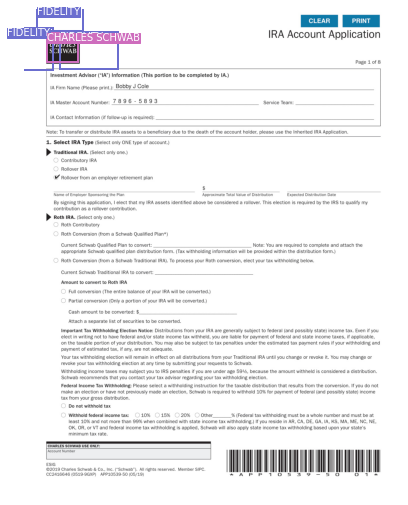

In [17]:
# load image and get detections
img_path = "/content/image17.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()